In [1]:
from utils import load_cnf, cnf_to_bqm, get_ancilla_index
def load_file(folder = 'sat', _variables=140):
    path = f"./{folder}/sgen1-{folder}-{_variables}-100.cnf"
    num_variables, num_clauses, variables, clauses = load_cnf(path)
    return num_variables, num_clauses, variables, clauses
def get_key_with_value(d, val):
    for (key, value) in d.items():
        if d[key] == val:
            return key
        
    return -1

def get_count_occurrences(key, clauses):
    ans = 0
    for clause in clauses:
        for var in clause:
            if abs(var) == key:
                ans += 1
    return ans

def mirror_variable(key, variables, clauses) -> (int, int):
    assert key > 0
    new_variable = len(variables) + 1 
    assert(new_variable not in variables)
    variables.add(new_variable)
    replacements = get_count_occurrences(key, clauses)//2
    if replacements == 0:
        return key, new_variable
    for clause in clauses:
        for i in range(len(clause)):
            if abs(clause[i]) == key:
                if clause[i] < 0:
                    clause[i] = -new_variable
                else:
                    clause[i] = new_variable
                replacements -= 1
                if replacements == 0:
                    return key, new_variable
    return -1, -1

In [2]:
num_variables, num_clauses, variables, clauses = load_file()

In [3]:
mirror_vars = [37,1,3,5,10,15,44,16,91,97,52,14,99,60,124,9,82,77,117,127,68,90,83,44,67,62,98,74,117,128,2,18,35,6,69,22,59,115,126,118,86,12,45,123,24,131,57,88, 40,11,101,111,112,47,134,107,87,95,103,114,130,36,28,84,116,65,133,139,27,178,359]
mirror_vars.sort()
len(mirror_vars)
print(mirror_vars)

[1, 2, 3, 5, 6, 9, 10, 11, 12, 14, 15, 16, 18, 22, 24, 27, 28, 35, 36, 37, 40, 44, 44, 45, 47, 52, 57, 59, 60, 62, 65, 67, 68, 69, 74, 77, 82, 83, 84, 86, 87, 88, 90, 91, 95, 97, 98, 99, 101, 103, 107, 111, 112, 114, 115, 116, 117, 117, 118, 123, 124, 126, 127, 128, 130, 131, 133, 134, 139, 178, 359]


In [4]:
variables_to_mirror = []
for var in mirror_vars:
    variables_to_mirror.append(mirror_variable(var, variables, clauses))

In [5]:
bqm, or_result_vars, clauses_qubits = cnf_to_bqm(variables, clauses)
len(bqm.variables)

379

In [6]:
def update_bqm_mirror_variable(original, mirror):
    global bqm
    bqm.add_variable(original, 2)
    bqm.add_variable(mirror, 2)
    bqm.add_interaction(original, mirror, -4)

In [7]:
for vtm in variables_to_mirror:
    update_bqm_mirror_variable(vtm[0], vtm[1])

----------------------------

In [8]:
from minorminer import find_embedding
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from greedy import SteepestDescentComposite
qpu_pegasus = DWaveSampler(solver={'topology__type': 'pegasus'})

<AxesSubplot:ylabel='Count'>

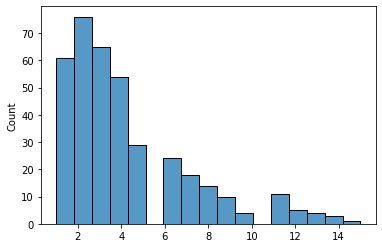

In [9]:
embedding = find_embedding(bqm.quadratic.keys(), qpu_pegasus.edgelist, random_seed=1238)

def get_chain_lengths(_embedding):
    lengths = []
    biases = []
    for (key, value) in _embedding.items():
        lengths.append(len(value))
        biases.append(bqm.linear[key])
    return lengths, biases

def count_qubits_used(embedding):
    physical_vars = set()
    for (logic_var, chain) in embedding.items():
        for pv in chain:
            physical_vars.add(pv)
        
    return len(physical_vars)

import seaborn as sns
sns.histplot(get_chain_lengths(embedding)[0])

In [10]:
count_qubits_used(embedding)

1571

In [11]:
for (logic_var, chains) in embedding.items():
    if len(chains) == 14:
        print(logic_var)

73
84
2


In [12]:
# sampler = SteepestDescentComposite(FixedEmbeddingComposite(DWaveSampler(solver={"name": "Advantage_system4.1"}), embedding))
# sampleset = sampler.sample(bqm, num_reads=1000, answer_mode='raw', chain_strength=2)
# sampleset.first.energy

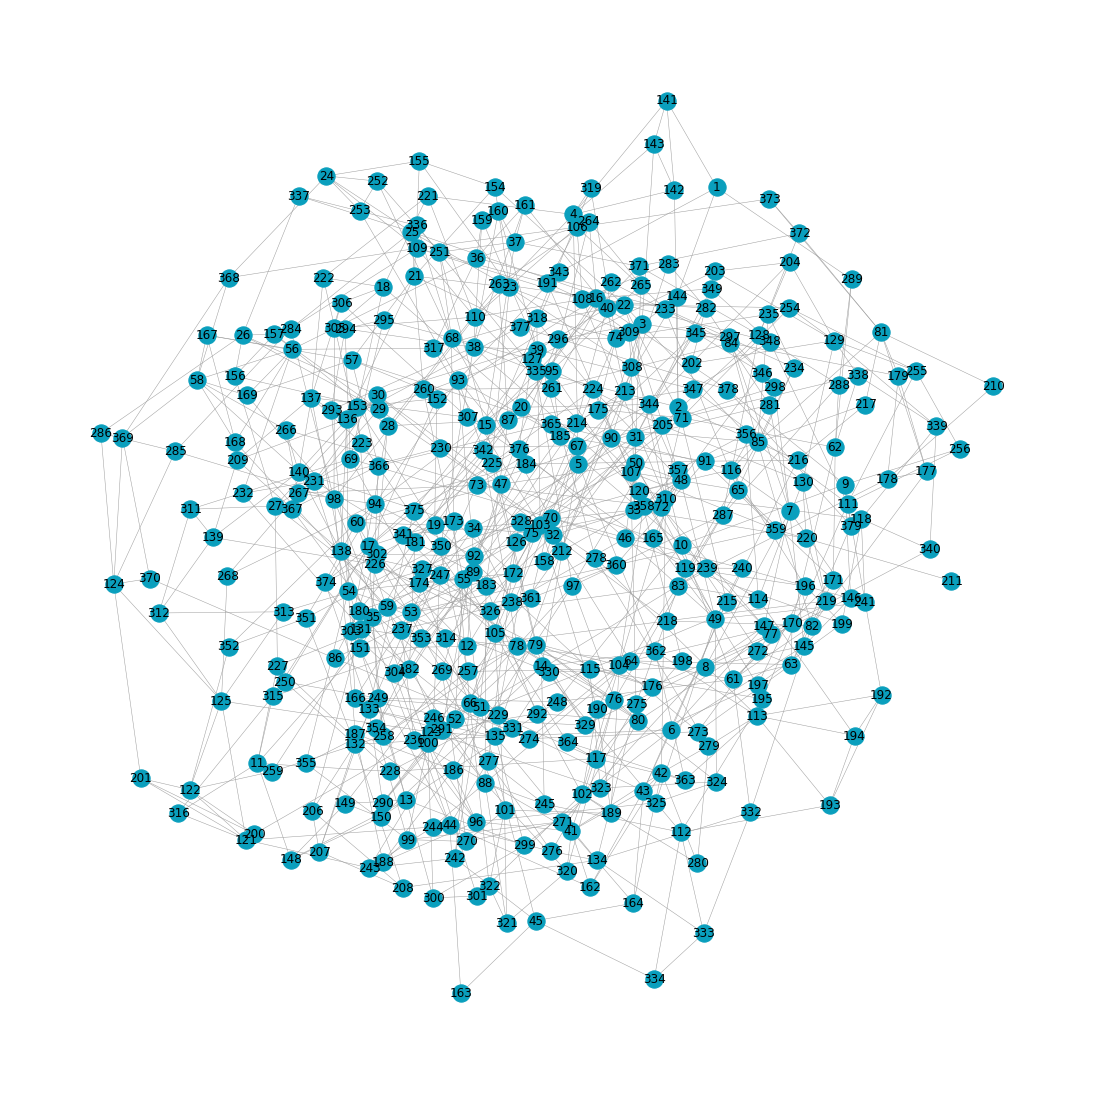

In [13]:
import dimod
bqm_graph = dimod.to_networkx_graph(bqm)
import networkx as nx
from matplotlib.pyplot import figure
figure(figsize=(15, 15))
nx.draw(bqm_graph, width=0.5, node_color="#0a9fbd", edge_color="#9e9e9e", with_labels=True)

In [14]:
for (key, value) in bqm.adj.items():
    if len(value) == 2:
        print(key)

163
198
210
